In [172]:
import pyads
from ctypes import sizeof
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import EarthLocation, Longitude
from astropy import units as u
import datetime
from time import sleep
import matplotlib.pyplot as plt
import numpy as np

In [10]:
'''
ADSSTATES:
{
    Invalid = 0,
    Idle = 1,
    Reset = 2,
    Init = 3,
    Start = 4,
    Run = 5,
    Stop = 6,
    SaveConfig = 7,
    LoadConfig = 8,
    PowerFailure = 9,
    PowerGood = 10,
    Error = 11,
    Shutdown = 12,
    Suspend = 13,
    Resume = 14,
    Config = 15,
    Reconfig = 16,
    Maxstates = 17,
}
'''

'\nADSSTATES:\n{\n    Invalid = 0,\n    Idle = 1,\n    Reset = 2,\n    Init = 3,\n    Start = 4,\n    Run = 5,\n    Stop = 6,\n    SaveConfig = 7,\n    LoadConfig = 8,\n    PowerFailure = 9,\n    PowerGood = 10,\n    Error = 11,\n    Shutdown = 12,\n    Suspend = 13,\n    Resume = 14,\n    Config = 15,\n    Reconfig = 16,\n    Maxstates = 17,\n}\n'

In [235]:
# for simple connection follow instructions of:
# http://soup01.com/en/2022/06/02/beckhoffusing-python-to-communicate-with-twincat-by-ads/

ads_net_id = '134.76.204.249.1.1' # net_id of PLC -> look at SYSTEM/Tasks/Routes
plc = pyads.Connection(ads_net_id, pyads.PORT_TC3PLC1) # create plc object with net_id and port 851
'''
print("Connecting to TwinCAT PLC..")
plc.open() # open plc connection
print("Current connection status:",plc.is_open)
print("Current Status:",plc.read_state())

print("Closing the Connections..")
plc.close()
print("Current Status:",plc.is_open)
'''
def test_JD2LST(time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m).geodetic
    #LST time
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')


    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    lat_b = plc.get_symbol('MAIN.lat')
    lon_b = plc.get_symbol('MAIN.lon')
    height_b = plc.get_symbol('MAIN.height')
    jd1_b = plc.get_symbol('MAIN.jd1')
    lst1_b = plc.get_symbol('MAIN.lst1')

    # write values to symbols
    lat_b.write(loc[0])
    lon_b.write(loc[1])
    height_b.write(loc[2])
    jd1_b.write(timeJD_astro)
    # change estate to execute test -> 5 == test_state.JD2LST
    plc.write_by_name(data_name='MAIN.estate', value=5,plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.05) # new cyle of twincat
    # get LST value
    LST_beck =  lst1_b.read()
    plc.close()
    #------------------------------------------------------------------------------------------
    return np.array([LST_astro.degree, LST_beck, LST_astro.degree-LST_beck])

# test run
now =  datetime.datetime.now()
# make time series
ts = TimeSeries(time_start=now,
                 time_delta=60 * u.min,
                 n_samples=500)
results = np.array([test_JD2LST(time) for time in ts.time])



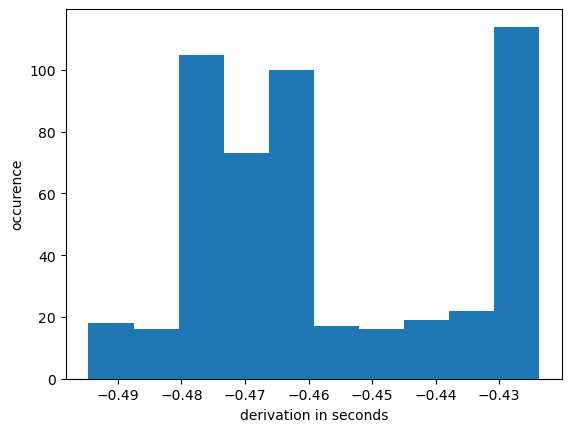

In [238]:
plt.hist(results[:,2]*3600/15)
plt.xlabel('derivation in seconds')
plt.ylabel('occurence')
plt.show()

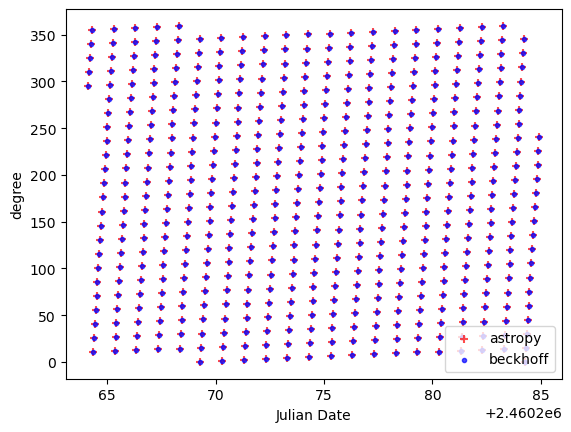

In [245]:
plt.scatter(ts.time.jd, results[:,0], marker='+', alpha=0.7, c='red', label='astropy')
plt.scatter(ts.time.jd, results[:,1], marker='.', alpha=0.7, c= 'blue', label='beckhoff')
plt.xlabel('Julian Date')
plt.ylabel('degree')
plt.legend()
plt.show()